In [9]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform

#### Plotting the log-uniform distribution

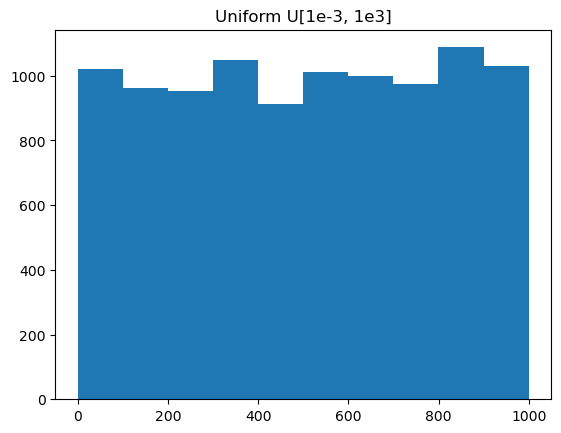

In [10]:
a, b, size = 1e-3, 1e3, 10000 
u = uniform(a, b, size)
fig, ax = plt.subplots()
ax.hist(u)
ax.set_title("Uniform U[1e-3, 1e3]")
plt.show()

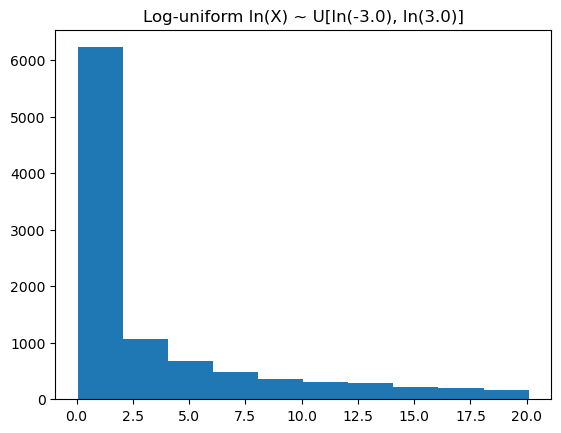

In [14]:
fig, ax = plt.subplots()
a, b, size = np.e**-3, np.e**3, 10000
u = uniform(np.log(a), np.log(b), size)
ax.hist(np.exp(u))
ax.set_title("Log-uniform ln(X) ~ U[ln({}), ln({})]".format(np.log(a), np.log(b)))
plt.show()